<a href="https://colab.research.google.com/github/Devansh30032004/SeizureEpilepsy_Classification/blob/main/Seizure_Epilepsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Remove all Qiskit-related packages
!pip uninstall -y qiskit qiskit-machine-learning qiskit-aer qiskit-ibmq-provider qiskit-algorithms qiskit-terra qiskit-experiments

# Clear pip cache
!pip cache purge

Found existing installation: qiskit 1.0.2
Uninstalling qiskit-1.0.2:
  Successfully uninstalled qiskit-1.0.2
Found existing installation: qiskit-machine-learning 0.7.1
Uninstalling qiskit-machine-learning-0.7.1:
  Successfully uninstalled qiskit-machine-learning-0.7.1
Found existing installation: qiskit-aer 0.13.1
Uninstalling qiskit-aer-0.13.1:
  Successfully uninstalled qiskit-aer-0.13.1
Found existing installation: qiskit-algorithms 0.3.1
Uninstalling qiskit-algorithms-0.3.1:
  Successfully uninstalled qiskit-algorithms-0.3.1
Files removed: 146


In [ ]:
!pip install "qiskit==1.0.2" \
            "qiskit-machine-learning==0.7.1" \
            "qiskit-aer==0.13.1" \
            "scikit-learn==1.3.2" \
            "numpy==1.23.5"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 20.5 MB/s eta 0:00:00


In [ ]:
!pip list | grep "qiskit\|scikit-learn"

qiskit                             1.0.2
qiskit-aer                         0.13.1
qiskit-algorithms                  0.3.1
qiskit-machine-learning            0.7.1
scikit-learn                       1.3.2


In [ ]:
!pip install \
  "numpy==1.23.5" \
  "scikit-learn==1.3.2" \
  "tensorflow==2.12.1" \
  "scipy==1.11.0" \
  "matplotlib==3.7.2"

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
from tensorflow import keras
from keras import layers

In [ ]:
import json
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

In [ ]:
file_path = "/content/seizureEEG.unknown"  # Update this path

with open(file_path, "r") as f:
    raw_data = f.read()

# Split the content based on spaces (ensuring to remove empty entries)
segments = [segment.strip() for segment in raw_data.split() if segment]

# Convert each segment (comma-separated values) into a NumPy array
eeg_signals = [np.array(segment.split(','), dtype=np.float32) for segment in segments]

# Stack signals into a 2D array if they all have the same length
eeg_signals = np.vstack(eeg_signals) if len(set(map(len, eeg_signals))) == 1 else eeg_signals

print("Number of EEG signals:", len(eeg_signals))
print("Shape of EEG signals:", eeg_signals.shape if isinstance(eeg_signals, np.ndarray) else "Varied lengths")

Number of EEG signals: 100
Shape of EEG signals: (100, 4097)


In [ ]:
file_path = "/content/seizureFreeEEG.unknown"  # Update this path

with open(file_path, "r") as f:
    raw_data = f.read()

# Split the content based on spaces (ensuring to remove empty entries)
segments = [segment.strip() for segment in raw_data.split() if segment]

# Convert each segment (comma-separated values) into a NumPy array
eeg_freesignals = [np.array(segment.split(','), dtype=np.float32) for segment in segments]

# Stack signals into a 2D array if they all have the same length
eeg_freesignals = np.vstack(eeg_freesignals) if len(set(map(len, eeg_freesignals))) == 1 else eeg_freesignals

print("Number of EEG signals:", len(eeg_freesignals))
print("Shape of EEG signals:", eeg_freesignals.shape if isinstance(eeg_freesignals, np.ndarray) else "Varied lengths")

Number of EEG signals: 100
Shape of EEG signals: (100, 4097)


In [ ]:
eeg_signals = np.concatenate((eeg_signals, eeg_freesignals), axis=0)
y1 = np.zeros(100, dtype=np.float32)
y2 = np.ones(100, dtype=np.float32)
y = np.concatenate((y2,y1))
eeg_signals.reshape(200,4097,-1)
y.reshape(200,1)
print(eeg_signals.shape)
print(y.shape)
eeg_signals[0].shape

(200, 4097)
(200,)


(4097,)

In [ ]:
def crop_eeg2(signal, window_size=100, stride=32):
    """
    Crops EEG signals into overlapping windows.

    Parameters:
    - signal: (Channels, Timepoints) NumPy array.
    - window_size: Length of each cropped segment.
    - stride: Overlap step size.

    Returns:
    - Cropped EEG segments as NumPy array.
    """
    total_samples = signal.shape
    total_sample = int(total_samples[0])
    #print(num_channels, total_samples)
    cropped_segments = []

    for start in range(0, total_sample - window_size + 1, stride):
        end = start + window_size
        cropped_segments.append(signal[start:end])

    return np.array(cropped_segments)  # Shape: (Num_Segments, Channels, Window_Size)

# Apply cropping to entire dataset
cropped_X1, cropped_y1 = [], []

window_size = 100  # Crop length
stride = 32  # Overlap step

for i in range(len(eeg_signals)):
    cropped_segments = crop_eeg2(eeg_signals[i], window_size, stride)
    cropped_X1.extend(cropped_segments)  # Add all cropped segments
    cropped_y1.extend([y[i]] * len(cropped_segments))  # Repeat label

cropped_X = np.array(cropped_X1)
cropped_y = np.array(cropped_y1)

print("Cropped EEG Data Shape:", cropped_X.shape)  # Expected: (Num_segments, Channels, Window_Size)
print("Updated Labels Shape:", cropped_y.shape)  # Expected: (Num_segments,)

Cropped EEG Data Shape: (25000, 100)
Updated Labels Shape: (25000,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cropped_X, cropped_y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17500, 100)
(7500, 100)
(17500,)
(7500,)


In [ ]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")

In [ ]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")

In [ ]:
y_train[y_train == 0] = -1
print(len(y_train[y_train == 1]))
len(y_train[y_train == -1])
y_test[y_test == 0] = -1
len(y_test[y_test == 1])

8748


3752

In [ ]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
initial_point = np.zeros(63)
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point
)

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#X_train1 = scaler.fit_transform(X_train)
#X_test1 = scaler.transform(X_test)
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()
X_train1 = X_train.reshape(-1,100)
X_test1 = X_test.reshape(-1,100)

In [ ]:
# Elu & sigmoid
input_dim = 100
encoding_dim = 8  # Target dimensionality

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='elu')(input_layer)
encoded = layers.Dense(32, activation='elu')(encoded)
encoded = layers.Dense(16, activation='elu')(encoded)
encoded = layers.Dense(encoding_dim, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='elu')(encoded)
decoded = layers.Dense(32, activation='elu')(encoded)
decoded = layers.Dense(64, activation='elu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder2 = keras.Model(input_layer, decoded)
autoencoder2.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder2.fit(X_train1, X_train1, epochs=50, batch_size=32, validation_data=(X_test1, X_test1), verbose=1)

# Create the encoder model
encoder2 = keras.Model(input_layer, encoded)

# Transform data to reduced dimensions
X_train_encoded2 = encoder2.predict(X_train1)
X_test_encoded2 = encoder2.predict(X_test1)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_encoded2.shape)

Epoch 1/50
547/547 [==============================] - 3s 3ms/step - loss: 0.0252 - val_loss: 0.0143
Epoch 2/50
547/547 [==============================] - 3s 5ms/step - loss: 0.0138 - val_loss: 0.0142
Epoch 3/50
547/547 [==============================] - 2s 3ms/step - loss: 0.0137 - val_loss: 0.0141
Epoch 4/50
547/547 [==============================] - 2s 3ms/step - loss: 0.0136 - val_loss: 0.0140
Epoch 5/50
547/547 [==============================] - 2s 3ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 6/50
547/547 [==============================] - 2s 3ms/step - loss: 0.0131 - val_loss: 0.0134
Epoch 7/50
547/547 [==============================] - 2s 3ms/step - loss: 0.0128 - val_loss: 0.0132
Epoch 8/50
547/547 [==============================] - 2s 3ms/step - loss: 0.0127 - val_loss: 0.0130
Epoch 9/50
547/547 [==============================] - 3s 5ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 10/50
547/547 [==============================] - 2s 4ms/step - loss: 0.0123 - val_loss: 0.0127

In [ ]:
print(X_train_encoded2[0])
len(y_test)

[0.8017138  0.48730648 0.6737934  0.02329736 0.24203706 0.54952824
 0.77366906 0.37730578]


7500

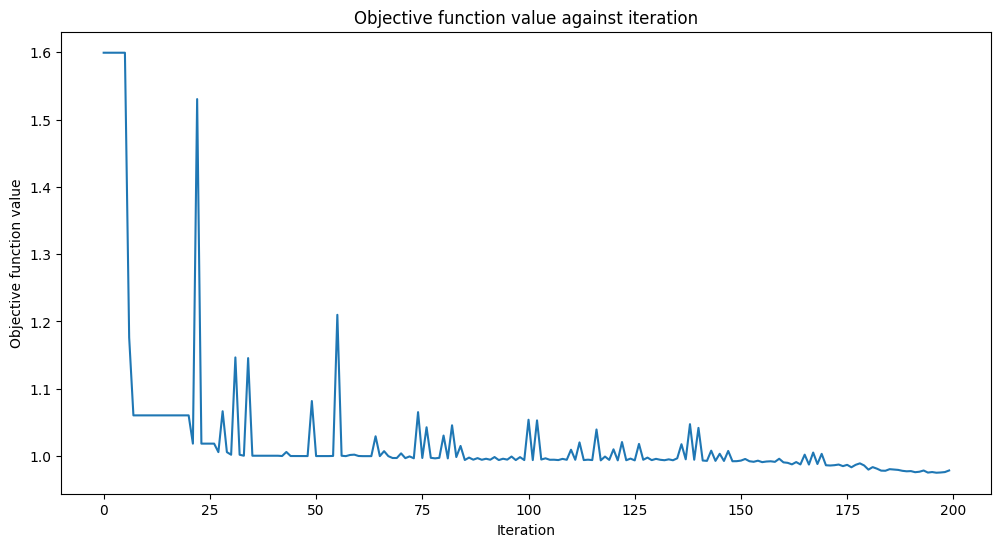

Accuracy from the train data : 77.1%
Accuracy from the test data : 76.38%


In [ ]:
x = np.asarray(X_train_encoded2[:6000])
y = np.asarray(y_train[:6000])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)
classifier.save('my_model.h5')
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
y_predict = classifier.predict(X_test_encoded2[:4000])
x1 = np.asarray(X_test_encoded2[:4000])
y1 = np.asarray(y_test[:4000])
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

In [ ]:
y_predict = classifier.predict(X_test_encoded2)
x1 = np.asarray(X_test_encoded2)
y1 = np.asarray(y_test)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

Accuracy from the test data : 76.4%
